In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from explore.grafic import GrafigCatNp as graf

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

import warnings
warnings.filterwarnings("ignore")

In [247]:
def results(model, x_train, x_test, y_train, y_test):
    predicciones = model.predict(X = x_test)
    predicciones_train = model.predict(X = x_train)

    print(f"El error (rmse) de test es: {mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)}")
    print(f"La precicion (r2) de test es: {r2_score(y_true  = y_test, y_pred  = predicciones)}")

    print('=='*50)

    print(f"El error (rmse) de test es: {mean_squared_error(y_true  = y_train, y_pred  = predicciones_train, squared = False)}")
    print(f"La precicion (r2) de train es: {r2_score(y_true  = y_train, y_pred  = predicciones_train)}")


In [4]:
datos = pd.read_csv('./housing.data', sep=' ')
datos.drop(columns='Unnamed: 0', axis=1, inplace=True)
grafic = graf(datos)
datos

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


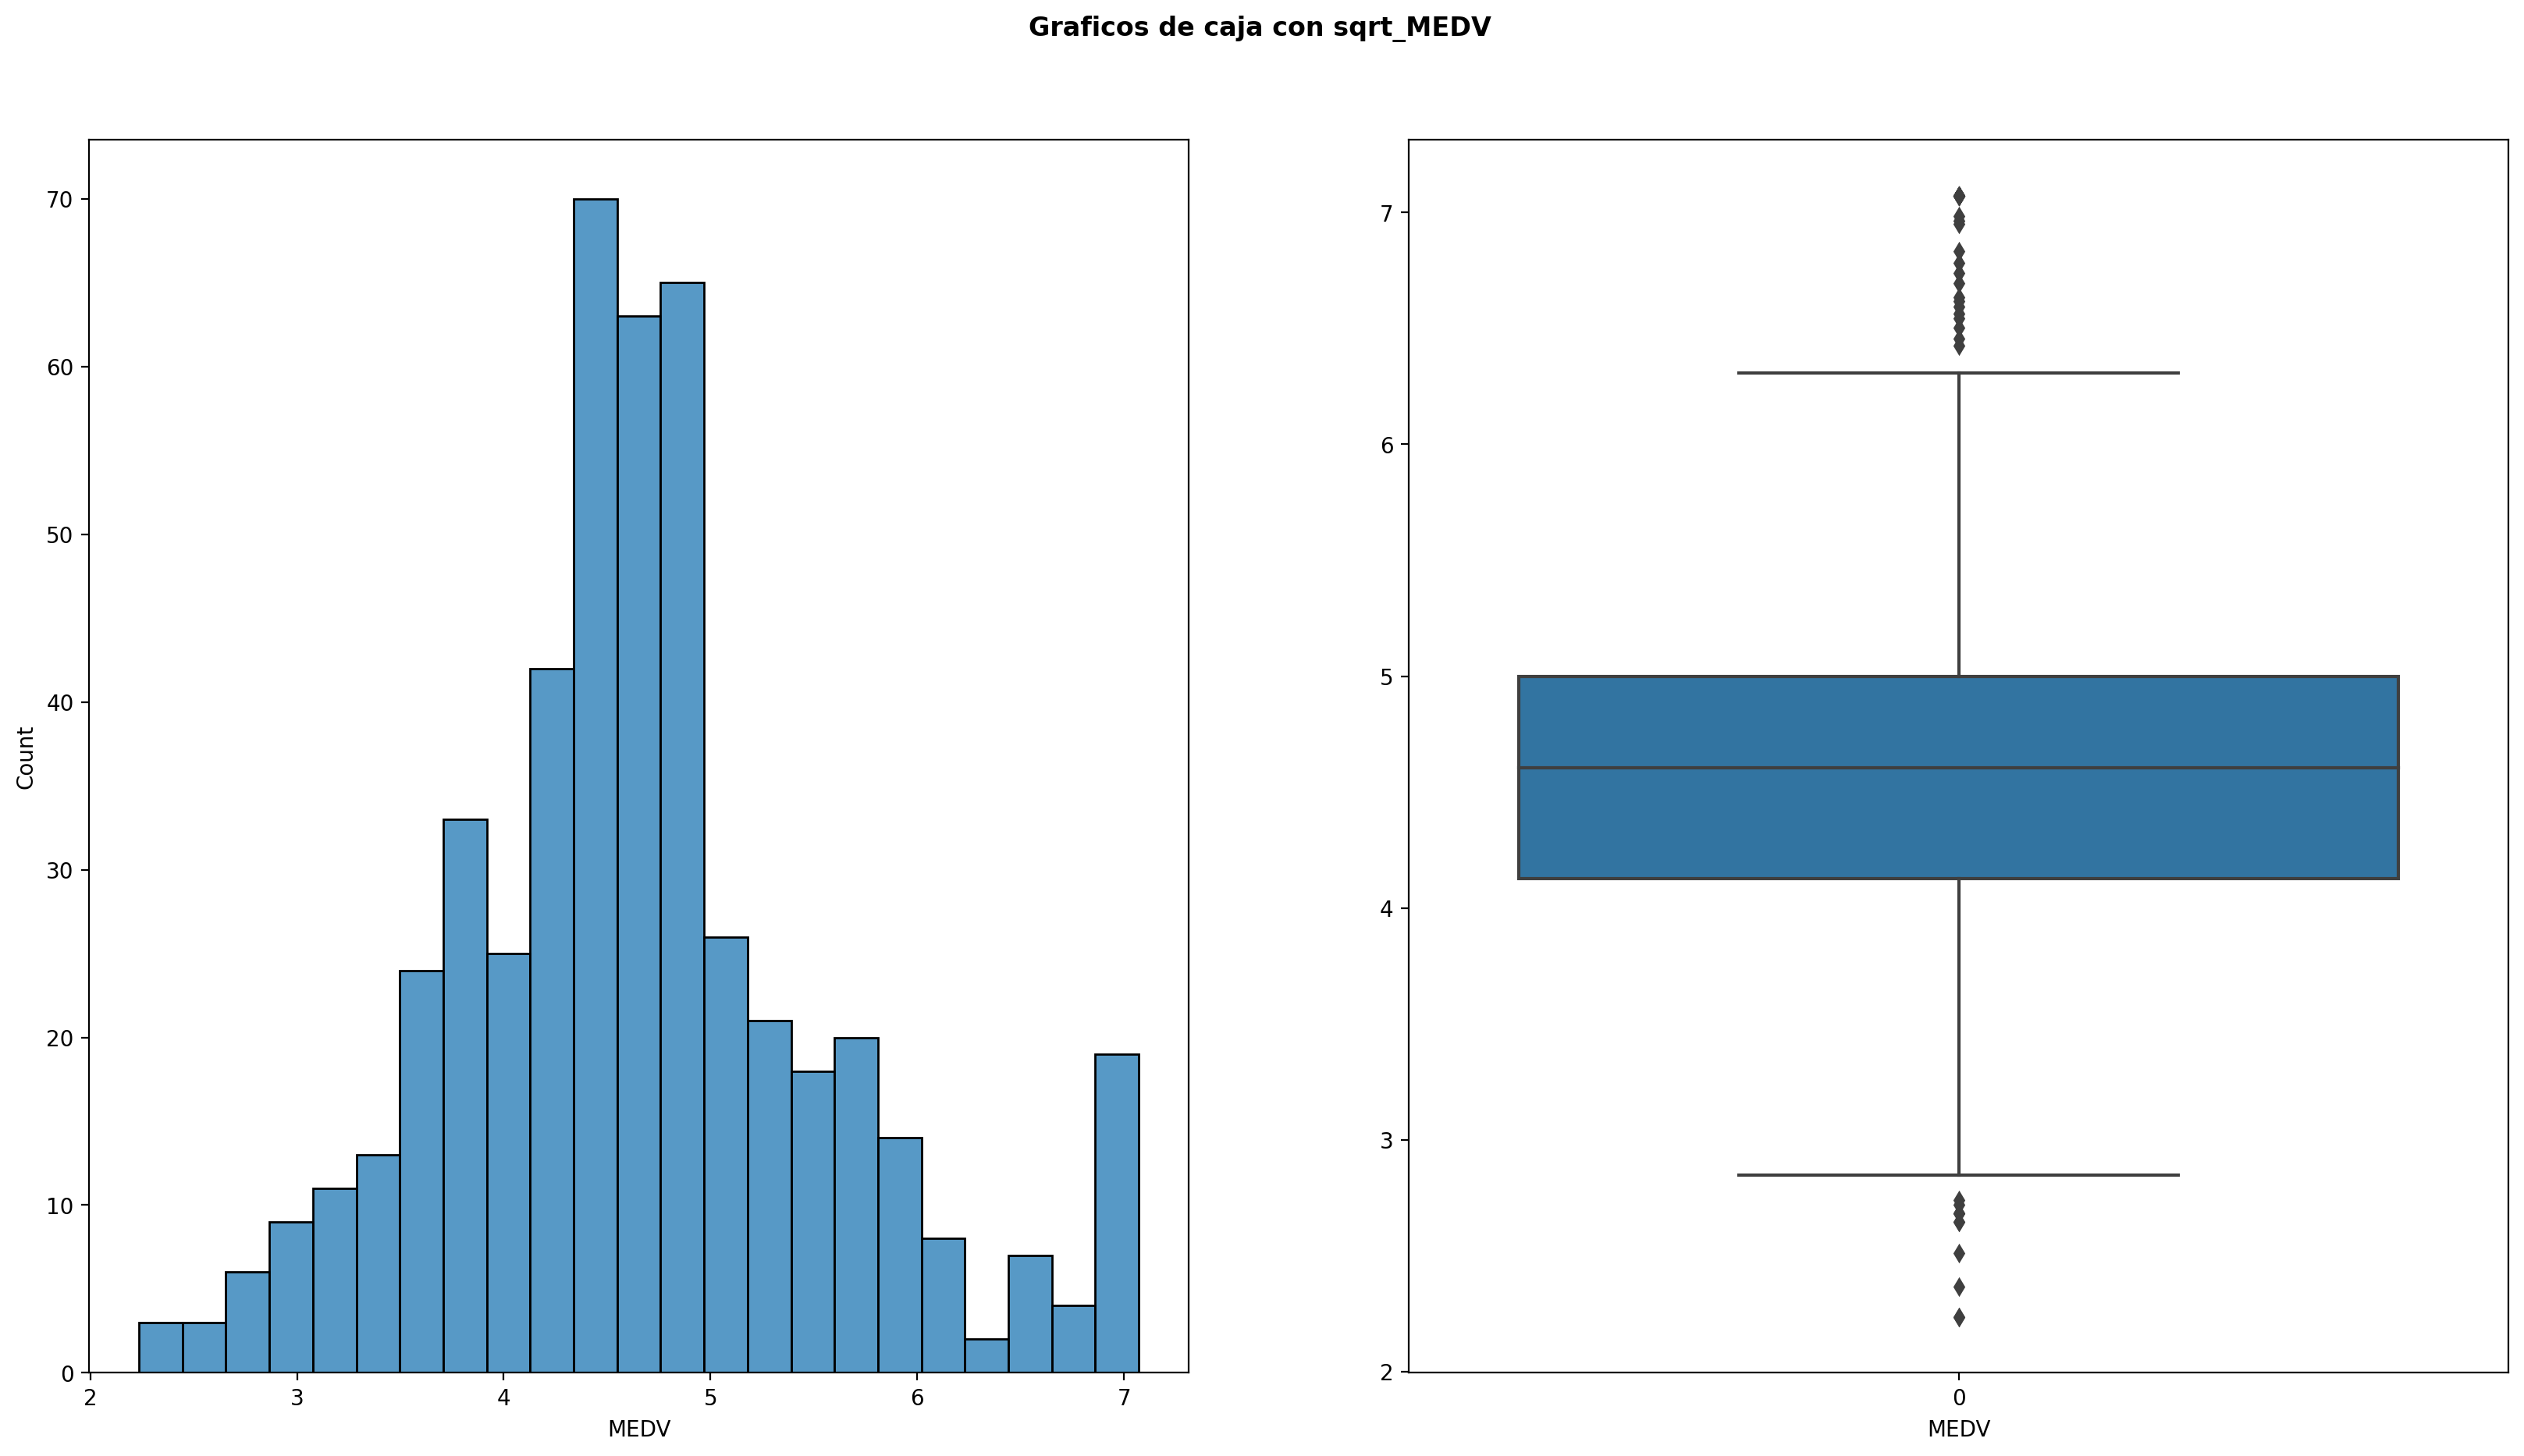

In [249]:
grafic.grafic_analist(variable='MEDV', distribution='sqrt')

In [250]:
datos['MEDV'] = np.sqrt(datos['MEDV'])

In [251]:
X = datos.drop(columns = "MEDV")
y = datos['MEDV']

In [252]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "MEDV"),
                                        datos['MEDV'],
                                        # random_state = 42
                                    )
# Creación del modelo
# ==============================================================================
modelo_single = RandomForestRegressor(
            oob_score    = True,
            random_state = 42,
            n_jobs       = -1,
            
         )

# Entrenamiento del modelo
# ==============================
# ================================================
modelo_single.fit(X_train, y_train)
modelo_single.estimators_[0]

print(len(modelo_single.estimators_))

print('=='*50)

print(modelo_single.oob_score_)

print('=='*50)

results(modelo_single, X_train, X_test, y_train, y_test)

pd.DataFrame({'Features':modelo_single.feature_names_in_, 'Imporantica':modelo_single.feature_importances_}).sort_values(by='Imporantica', ascending=False)

100
0.8569292527581527
El error (rmse) de test es: 0.32331446523425306
La precicion (r2) de test es: 0.88342969884855
El error (rmse) de test es: 0.13330732242580198
La precicion (r2) de train es: 0.9794834345865774


,Features,Imporantica
12,LSTAT,0.458496
5,RM,0.320574
0,CRIM,0.057959
7,DIS,0.044983
4,NOX,0.041696
9,TAX,0.019587
6,AGE,0.016130
10,PTRATIO,0.014274
11,B,0.012957
2,INDUS,0.006905


In [253]:
X = datos.drop(columns=["MEDV",'ZN'])

In [254]:
kf = KFold(5)

param_grid = {'n_estimators':range(150, 160, 1)}

grid = GridSearchCV(
    estimator       = RandomForestRegressor(
                        criterion   = 'poisson',
                        n_jobs      = -1,
                        random_state= 123,
                        oob_score   = True
    ),
    param_grid      = param_grid,
    cv              = kf,
    return_train_score = True
)

grid.fit(X,y)

modelo_n_estimators = grid.best_estimator_

print(f'Best_model, oob_score   : {modelo_n_estimators.oob_score_}')
print(f'Cross Validate promedio : {cross_val_score(modelo_n_estimators, X, y).mean()}')
print(f'Best_params, n_estimator: {grid.best_params_}')

pd.DataFrame(grid.cv_results_).drop(columns=['mean_fit_time','std_fit_time','mean_score_time','std_score_time','params']).sort_values(by='rank_test_score').head(2)

Best_model, oob_score   : 0.8786542772225778
Cross Validate promedio : 0.6741667112747065
Best_params, n_estimator: {'n_estimators': 158}


,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
8,158,0.741862,0.82612,0.742220,0.593229,0.467402,0.674167,0.127755,1,0.983993,0.981265,0.979631,0.984136,0.983362,0.982478,0.001755
9,159,0.741760,0.82626,0.740456,0.592938,0.466754,0.673634,0.127837,2,0.984028,0.981336,0.979657,0.984135,0.983372,0.982506,0.001744


In [255]:
pd.DataFrame({'Variable':modelo_n_estimators.feature_names_in_,'Importancia':modelo_n_estimators.feature_importances_}).sort_values(by='Importancia', ascending=False)

,Variable,Importancia
11,LSTAT,0.568148
4,RM,0.206648
0,CRIM,0.063767
6,DIS,0.051594
3,NOX,0.036007
10,B,0.017089
5,AGE,0.016592
8,TAX,0.015549
9,PTRATIO,0.013044
1,INDUS,0.007081


In [256]:
kf = KFold(5)

param_grid = {'max_features':range(1, X.shape[1]+1, 1)}

grid = GridSearchCV(
    estimator       = RandomForestRegressor(
                        n_estimators= 158,
                        criterion   = 'poisson',
                        n_jobs      = -1,
                        random_state= 123,
                        oob_score   = True
    ),
    param_grid      = param_grid,
    cv              = kf,
    return_train_score = True
)

grid.fit(X,y)

modelo_max_features = grid.best_estimator_

print(f'Best_model, oob_score    : {modelo_max_features.oob_score_}')
print(f'Cross Validate promedio  : {cross_val_score(modelo_max_features, X, y).mean()}')
print(f'Best_params, max_features: {grid.best_params_}')

pd.DataFrame(grid.cv_results_).drop(columns=['mean_fit_time','std_fit_time','mean_score_time','std_score_time','params']).sort_values(by='rank_test_score').head(2)

Best_model, oob_score    : 0.8867885094108116
Cross Validate promedio  : 0.7033578872971843
Best_params, max_features: {'max_features': 7}


,param_max_features,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,7,0.743655,0.871699,0.778682,0.616637,0.506118,0.703358,0.128110,1,0.985483,0.983159,0.979773,0.985584,0.984539,0.983707,0.002151
4,5,0.755210,0.868306,0.777898,0.603800,0.480569,0.697157,0.137701,2,0.985003,0.983136,0.981317,0.986392,0.984230,0.984016,0.001716


In [257]:
kf = KFold(5)

param_grid = {'max_depth':range(10, 30, 1)}

grid = GridSearchCV(
    estimator       = RandomForestRegressor(
                        n_estimators= 158,
                        criterion   = 'poisson',
                        max_features= 7,
                        n_jobs      = -1,
                        random_state= 123,
                        oob_score   = True
    ),
    param_grid      = param_grid,
    cv              = kf,
    return_train_score = True
)

grid.fit(X,y)

modelo_max_depth = grid.best_estimator_

print(f'Best_model, oob_score    : {modelo_max_depth.oob_score_}')
print(f'Cross Validate promedio  : {cross_val_score(modelo_max_depth, X, y).mean()}')
print(f'Best_params, max_features: {grid.best_params_}')

pd.DataFrame(grid.cv_results_).drop(columns=['mean_fit_time','std_fit_time','mean_score_time','std_score_time','params']).sort_values(by='rank_test_score').head(2)

Best_model, oob_score    : 0.8848558793303557
Cross Validate promedio  : 0.7045405710314829
Best_params, max_features: {'max_depth': 17}


,param_max_depth,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
7,17,0.735655,0.870677,0.782024,0.624583,0.509763,0.704541,0.125622,1,0.985595,0.983068,0.979600,0.985820,0.984316,0.983680,0.002266
8,18,0.740131,0.873168,0.772107,0.617671,0.519317,0.704479,0.123387,2,0.985584,0.983024,0.980038,0.985631,0.984287,0.983713,0.002073


In [258]:
# División de los datos en train y test
# ==============================================================================
X_train_test, X_test_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        # random_state = 42
                                    )

# Creación del modelo
# ==============================================================================
modelo_single = RandomForestRegressor(
            n_estimators = 158,
            criterion    = 'poisson',
            max_features = 5,
            max_depth    = 17,
            oob_score    = True,
            random_state = 123,
            n_jobs       = -1,
            
         )

# Entrenamiento del modelo
# ==============================
# ================================================
modelo_single.fit(X_train_test, y_train)


print(f'oob_score: {modelo_single.oob_score_}')

print('=='*50)

results(modelo_single, X_train_test, X_test_test, y_train, y_test)

pd.DataFrame({'Features':modelo_single.feature_names_in_, 'Imporantica':modelo_single.feature_importances_}).sort_values(by='Imporantica', ascending=False)

oob_score: 0.889369391254998
El error (rmse) de test es: 0.4634503818288403
La precicion (r2) de test es: 0.7475070519145843
El error (rmse) de test es: 0.11604643175531552
La precicion (r2) de train es: 0.9847463150804987


,Features,Imporantica
11,LSTAT,0.332388
4,RM,0.266545
0,CRIM,0.136327
3,NOX,0.080626
9,PTRATIO,0.046803
6,DIS,0.042423
1,INDUS,0.024088
5,AGE,0.023358
10,B,0.019777
8,TAX,0.016573
